# Met Office COVID-19 response dataset

This dataset is created, curated and updated for researchers looking to understand links between COVID-19 and environmental factors. 

For more information check out our [blog post](https://medium.com/informatics-lab/met-office-and-partners-offer-data-and-compute-platform-for-covid-19-researchers-83848ac55f5f) and the [data readme](https://metdatasa.blob.core.windows.net/covid19-response/README_data.html)

We are constantly updating the available data, [subscribe to our news group](https://groups.google.com/forum/#!forum/met-office-covid-19-data-and-platform-updates/join) to stay up to date or [contact us](mailto:covid19@informaticslab.co.uk) if you have any requests.

This Notebook offers some examples of how to interact with the data but if you need any help please contact covid19@informaticslab.co.uk.


## Imports and globals
Import the required modules, set up the default plot size and set some constants

In [ ]:
%load_ext nb_black

In [7]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, ContentSettings

from IPython.display import Markdown
import matplotlib.pyplot as plt 
%matplotlib inline 
import datetime
from collections import namedtuple
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import os

## Set up the blob client with the connection details

In [2]:
ACCOUNT_URL="https://metdatasa.blob.core.windows.net"
CONTAINER='covid19-response'

In [3]:
# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient(ACCOUNT_URL)
container_client = blob_service_client.get_container_client(CONTAINER)

## Get a particular file based on the data required

The filenames are predictable, if you know what data you want you can download that file

In [4]:
DATA_END = (datetime.datetime.now() - datetime.timedelta(days=9)).date()
DATA_START = datetime.date(2020,1,1)

def url_from_propertys(model, param, freq, stat=None, day=None, hour=None):
    assert model in ["global","ukv"]
    assert param in ["rain", "sh", "snow", "t1o5m", "pmsl","precip","sw"]
    assert freq in ["daily","hourly"]
    if freq == 'daily':
        assert stat in ['max', 'min', 'mean']
    else:
        assert stat is None  
    assert DATA_START <= day <= DATA_END
    
    stat = '_'+stat if stat else ''

    filepath = f'metoffice_{model}_{freq}/{param}{stat}/{model}_{freq}_{param}{stat}_{day:%Y%m%d}.nc'
    return f"{ACCOUNT_URL}/{CONTAINER}/{filepath}"


Properties = namedtuple('Properties',["model","param","freq","stat","day"])

In [5]:

files = [
    Properties("global","precip","daily","mean",datetime.date(2020,3,3)),
    Properties("ukv","t1o5m","daily","min",datetime.date(2020,4,1)),
    Properties("ukv","snow","hourly",None,datetime.date(2020,2,2)),
]

for file in files:
    path = url_from_propertys(*file)
    print(path)

https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200303.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_ukv_daily/t1o5m_min/ukv_daily_t1o5m_min_20200401.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_ukv_hourly/snow/ukv_hourly_snow_20200202.nc


## xarray or Iris are useful tools for interacting with this sort of data

In [6]:
import xarray as xr

Stream blob into memory and load dataset in xarray

In [42]:
from io import BytesIO
# TODO: how to read more than one day easily?
data_description = Properties("global","precip","daily","mean",datetime.date(2020,1,30))

In [86]:
ds = xr.Dataset()

file_varnames = ['precip', "t1o5m"]
xr_varnames = ['precipitation_flux','air_temperature']
for i,var in enumerate(file_varnames):
    xr_var = xr_varnames[i]
    da = []
    for day in [1,2,3]:
        data_description = Properties("global",var,"daily","mean",datetime.date(2020,2,day))
        print(url_from_propertys(*data_description))
        file_data = BytesIO(BlobClient.from_blob_url(url_from_propertys(*data_description)).download_blob().readall())
        da.append(xr.open_dataset(file_data)[xr_var].squeeze())
    da = xr.concat(da,dim='time')
    # take time of first variable
    if i != 0:
        da['time']=ds.time
    ds[xr_var]=da

https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200201.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200202.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/precip_mean/global_daily_precip_mean_20200203.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/t1o5m_mean/global_daily_t1o5m_mean_20200201.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/t1o5m_mean/global_daily_t1o5m_mean_20200202.nc
https://metdatasa.blob.core.windows.net/covid19-response/metoffice_global_daily/t1o5m_mean/global_daily_t1o5m_mean_20200203.nc


In [ ]:
ds=ds.assign(longitude=ds.longitude-180)

In [88]:
drop = ['forecast_reference_time','forecast_period']
ds = ds.rename({'longitude':'lon','latitude':'lat'}).drop(drop)

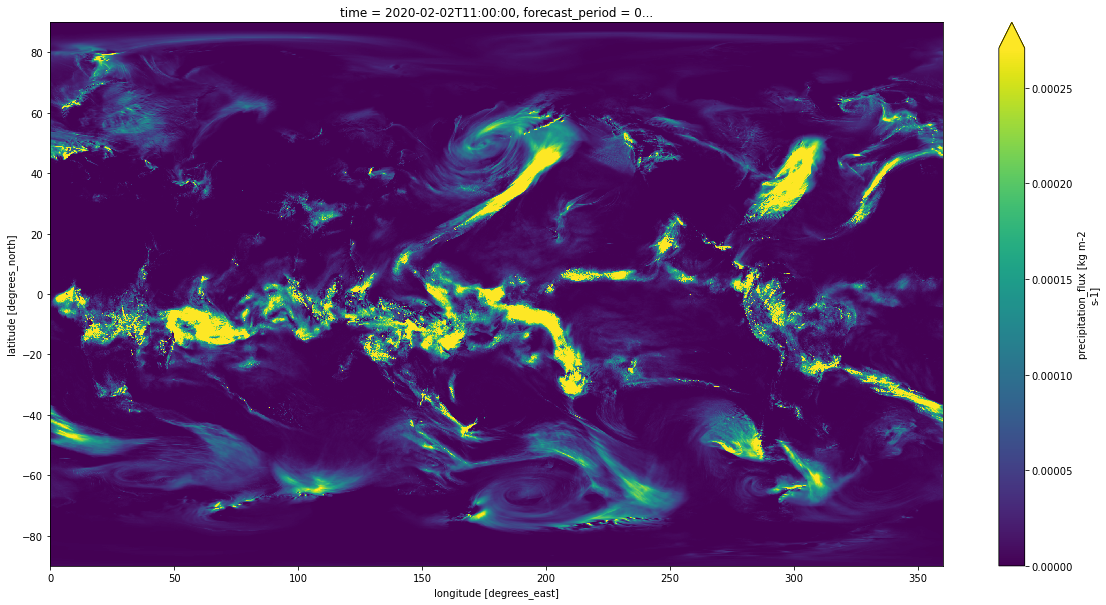

In [94]:
ds.precipitation_flux.isel(time=1).plot(robust=True)

# masking

In [95]:
import regionmask

import geopandas

In [2]:
import yaml
# getting info from yaml into dict
fn = 'country_config.yaml'
with open(fn) as f:
    country_dict = yaml.safe_load(f)
f.close()

In [3]:
country_dict

{'UK': {'keywords': ['United Kingdom', 'England'],
  'base': 'https://metdatasa.blob.core.windows.net/covid19-response/shapefiles/England',
  'name': 'Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BUC',
  'from_geopandas_args': {'names': 'ctyua19nm', 'abbrevs': 'ctyua19cd'}}}

In [4]:
with open(fn, 'r') as f:
    metadata = yaml.safe_load(f)
    keywords_dict = {}
    for k, v in metadata.items():
        keywords_dict.update({k: k})
        for keyword in v['keywords']:
            keywords_dict.update({keyword: k})
keywords_dict

{'United Kingdom': 'UK', 'England': 'UK'}

In [2]:
def download_shapefile(country):
    name = country_dict[country]['name']
    base = country_dict[country]['base']
    for ending in ['shx','dbf','shp']:
        filename = f"{name}.{ending}"
        url = f'{base}/{filename}'
        with open(filename, "wb") as f:
            print(f'Download {url} to {filename}')
            data = BlobClient.from_blob_url(url).download_blob()
            data.readinto(f)

In [ ]:
import os
country='UK'
# convert keyword to real dataset key
if country not in keywords_dict:
    raise ValueError(f"{country} not found in keywords: Please select from {keywords_dict.keys()}.")
country = keywords_dict[country]

In [ ]:
filename = country_dict[country]['name'] + '.shp'
if not os.path.exists(filename):
    download_shapefile(country)
gdf = geopandas.read_file(filename)
# os.remove(country_dict[country]['name']+)
gdf.head()

In [99]:
# create region with regionmask
names = country_dict[country]['from_geopandas_args']['names']
abbrevs = country_dict[country]['from_geopandas_args']['abbrevs']
%time regions = regionmask.from_geopandas(gdf,names=names,abbrevs=abbrevs,name=f'{country} regions')

CPU times: user 15.2 ms, sys: 2.84 ms, total: 18 ms
Wall time: 15.4 ms


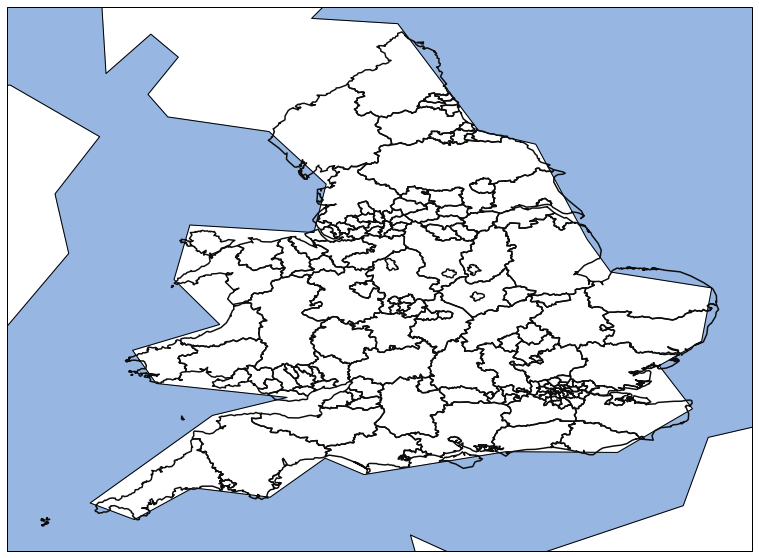

In [100]:
regions.plot(add_label=False)

In [ ]:
# todo: local subsetting will bring another performance increase
regions.bounds_global

In [ ]:
%time regions_masked = regions.mask(ds)

In [ ]:
# groupby masked regions
%time ds_region = ds.groupby(regions_masked).mean('stacked_lat_lon')

In [ ]:
def set_labels(ds,region):
    abbrevs = region[ds.region.values].abbrevs
    names = region[ds.region.values].names

    ds.coords['abbrevs'] = ('region', abbrevs)
    ds.coords['names'] = ('region', names)
    return ds

In [ ]:
ds_region = set_labels(ds_region, regions)

In [ ]:
ds_region

In [ ]:
for v in ds_region.data_vars:
    ds_region[v].plot(hue='region',add_legend=False)
    plt.show()

In [ ]:
ds_region.to_dataframe()